In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import optuna

warnings.simplefilter('ignore', FutureWarning)

!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

In [3]:
train_df = pd.read_csv('/kaggle/input/data-split/train_split/10/train_october.csv')
test_df = pd.read_csv('/kaggle/input/data-split/train_split/10/test_october.csv')

In [4]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

## Chuẩn hóa

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Chọn feature

In [6]:
top_features =  ['EWSS', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SSHF', 'TCLW', 'TCW', 'U250', 'U850', 'V250', 'V850', 'B11B', 'B14B', 'I4B', 'IRB']

## Hàm bổ trợ

In [7]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [8]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, top_features=None):
    model_rf = RandomForestClassifier(random_state=42)
    
    if top_features is not None:
        X_train = X_train[top_features]
        X_test = X_test[top_features]

    model_rf.fit(X_train, y_train)
    
    y_pred = model_rf.predict(X_test)
    
    print_scores(y_test, y_pred)

In [9]:
def objective(trial, X_train_scaled, y_train, X_test_scaled, y_test, 
              use_smote=False, use_smoteenn=False, top_features=None):
    # Tối ưu hóa các tham số cho Random Forest
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),  
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']), 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced_subsample']),
        'random_state': 42,
        'n_jobs': -1
    }

    # Sử dụng top_features để chọn các đặc trưng quan trọng
    if top_features is not None:
        X_train_scaled = X_train_scaled[top_features]
        X_test_scaled = X_test_scaled[top_features]

    model = RandomForestClassifier(**param)
    model.fit(X_train_scaled, y_train)
    
    # Dự đoán xác suất và tối ưu hóa threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    best_thresh = trial.suggest_float('threshold', 0.1, 0.9, step=0.05)
    y_pred = (y_probs >= best_thresh).astype(int)

    return f1_score(y_test, y_pred, pos_label=1)


In [10]:
def optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,
                       use_smote=False, use_smoteenn=False,
                       top_features=None,
                       n_trials=20, timeout=1200):  
    study = optuna.create_study(direction='maximize')
    
    study.optimize(lambda trial: objective(trial, X_train_scaled, y_train, X_test_scaled, y_test,
                                           use_smote, use_smoteenn, top_features),
                   n_trials=n_trials, timeout=timeout)

    print("Best trial:")
    print(study.best_trial)
    print("Best hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")

    best_params = study.best_trial.params
    best_thresh = best_params.pop('threshold')

    best_params.update({
        'random_state': 42,
        'n_jobs': -1
    })
    
    best_model = RandomForestClassifier(**best_params)
    best_model.fit(X_train_scaled, y_train)

    y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_thresh = (y_probs >= best_thresh).astype(int)

    print(f"Best threshold: {best_thresh}")
    print_scores(y_test, y_pred_thresh)

# Không SMOTE

## Data

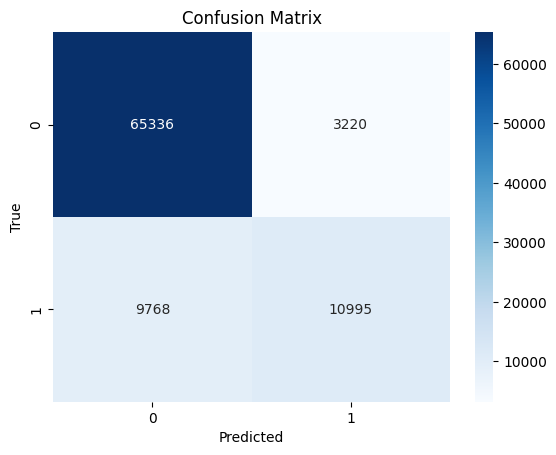

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     68556
           1       0.77      0.53      0.63     20763

    accuracy                           0.85     89319
   macro avg       0.82      0.74      0.77     89319
weighted avg       0.85      0.85      0.84     89319



In [11]:
train_and_evaluate_rf(X_train_scaled, y_train, X_test_scaled, y_test)

## Data tune

[I 2025-05-05 17:38:31,455] A new study created in memory with name: no-name-426fcf8d-9ef1-4232-a7cd-1e46d0bcf341
[I 2025-05-05 17:40:00,004] Trial 0 finished with value: 0.6316029924047741 and parameters: {'n_estimators': 171, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.6}. Best is trial 0 with value: 0.6316029924047741.
[I 2025-05-05 17:41:50,202] Trial 1 finished with value: 0.6967806447405605 and parameters: {'n_estimators': 177, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.4}. Best is trial 1 with value: 0.6967806447405605.
[I 2025-05-05 17:43:16,051] Trial 2 finished with value: 0.5740638415437582 and parameters: {'n_estimators': 176, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.2}. Best is trial

Best trial:
FrozenTrial(number=1, state=1, values=[0.6967806447405605], datetime_start=datetime.datetime(2025, 5, 5, 17, 40, 0, 5490), datetime_complete=datetime.datetime(2025, 5, 5, 17, 41, 50, 201860), params={'n_estimators': 177, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=1, value=None)
Best hyperparameters:
n_estimat

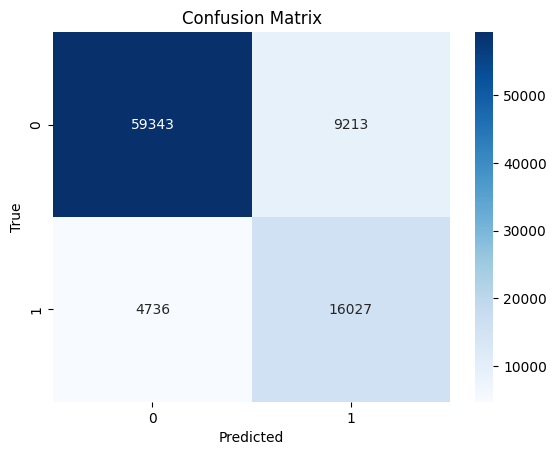

              precision    recall  f1-score   support

           0       0.93      0.87      0.89     68556
           1       0.63      0.77      0.70     20763

    accuracy                           0.84     89319
   macro avg       0.78      0.82      0.80     89319
weighted avg       0.86      0.84      0.85     89319



In [12]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test)

## Data + feature

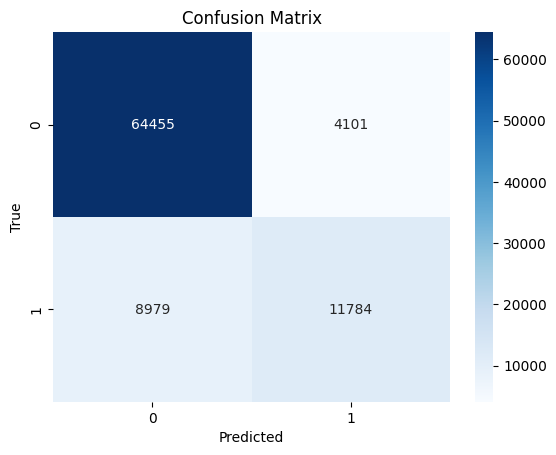

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     68556
           1       0.74      0.57      0.64     20763

    accuracy                           0.85     89319
   macro avg       0.81      0.75      0.78     89319
weighted avg       0.85      0.85      0.85     89319



In [13]:
train_and_evaluate_rf(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + Feature + Tune

[I 2025-05-05 18:04:01,541] A new study created in memory with name: no-name-2c82fc03-eeb8-4d81-be52-ee4f12291027
[I 2025-05-05 18:05:04,270] Trial 0 finished with value: 0.4597771644689769 and parameters: {'n_estimators': 113, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.65}. Best is trial 0 with value: 0.4597771644689769.
[I 2025-05-05 18:06:22,654] Trial 1 finished with value: 0.37947689106850946 and parameters: {'n_estimators': 142, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.75}. Best is trial 0 with value: 0.4597771644689769.
[I 2025-05-05 18:08:47,214] Trial 2 finished with value: 0.6404404136407751 and parameters: {'n_estimators': 289, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.3000000000000

Best trial:
FrozenTrial(number=10, state=1, values=[0.6786637502485583], datetime_start=datetime.datetime(2025, 5, 5, 18, 20, 31, 423096), datetime_complete=datetime.datetime(2025, 5, 5, 18, 22, 37, 348626), params={'n_estimators': 239, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=10, value=None)
Best hyperparameters:
n_es

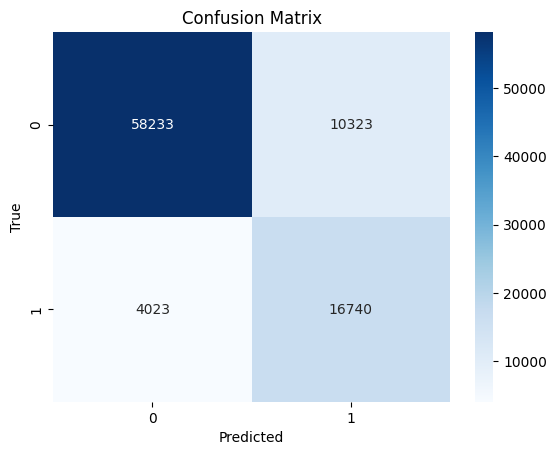

              precision    recall  f1-score   support

           0       0.94      0.85      0.89     68556
           1       0.62      0.81      0.70     20763

    accuracy                           0.84     89319
   macro avg       0.78      0.83      0.80     89319
weighted avg       0.86      0.84      0.85     89319



In [14]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

# SMOTE

In [15]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE 

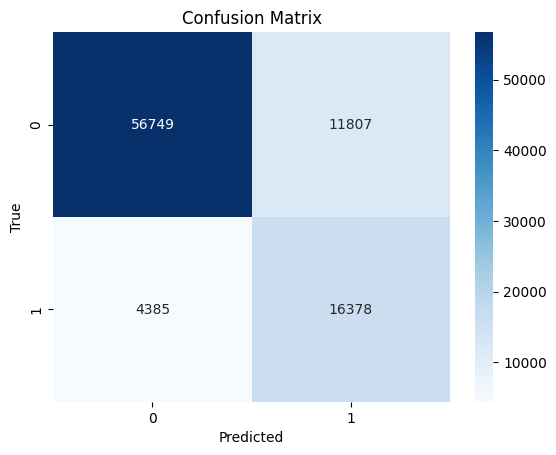

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     68556
           1       0.58      0.79      0.67     20763

    accuracy                           0.82     89319
   macro avg       0.75      0.81      0.77     89319
weighted avg       0.85      0.82      0.83     89319



In [16]:
train_and_evaluate_rf(X_train_scaled, y_sm, X_test_scaled, y_test)

## Data SMOTE + Tune

[I 2025-05-05 18:33:14,157] A new study created in memory with name: no-name-3fae261d-9489-448d-b5d6-ece96e1b5214
[I 2025-05-05 18:36:19,276] Trial 0 finished with value: 0.6450670561678397 and parameters: {'n_estimators': 166, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.7000000000000001}. Best is trial 0 with value: 0.6450670561678397.
[I 2025-05-05 18:40:13,890] Trial 1 finished with value: 0.661485448893217 and parameters: {'n_estimators': 207, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.45000000000000007}. Best is trial 1 with value: 0.661485448893217.
[I 2025-05-05 18:43:33,713] Trial 2 finished with value: 0.6751390379549224 and parameters: {'n_estimators': 181, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'th

Best trial:
FrozenTrial(number=2, state=1, values=[0.6751390379549224], datetime_start=datetime.datetime(2025, 5, 5, 18, 40, 13, 891606), datetime_complete=datetime.datetime(2025, 5, 5, 18, 43, 33, 713064), params={'n_estimators': 181, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.65}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=2, value=None)
Best hyperparameters:
n_est

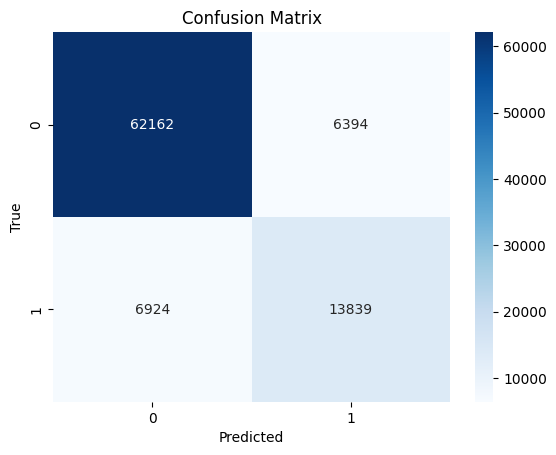

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     68556
           1       0.68      0.67      0.68     20763

    accuracy                           0.85     89319
   macro avg       0.79      0.79      0.79     89319
weighted avg       0.85      0.85      0.85     89319



In [17]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, use_smote=True)

## Data SMOTE + Feature

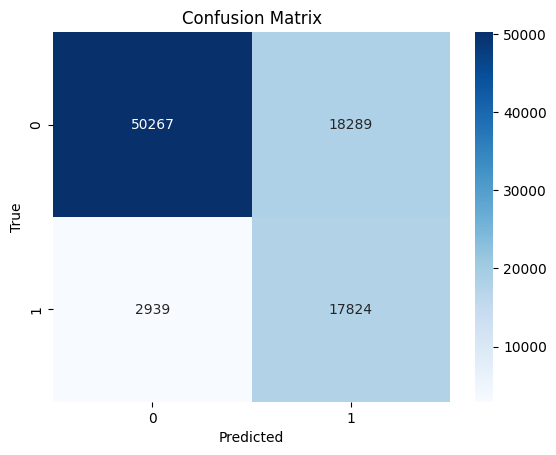

              precision    recall  f1-score   support

           0       0.94      0.73      0.83     68556
           1       0.49      0.86      0.63     20763

    accuracy                           0.76     89319
   macro avg       0.72      0.80      0.73     89319
weighted avg       0.84      0.76      0.78     89319



In [18]:
train_and_evaluate_rf(X_train_scaled, y_sm, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE + Feature + Tune

[I 2025-05-05 19:04:48,610] A new study created in memory with name: no-name-902fe6a1-5c9f-4875-bec1-98807ff7722d
[I 2025-05-05 19:09:37,346] Trial 0 finished with value: 0.6444983304181905 and parameters: {'n_estimators': 253, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.6}. Best is trial 0 with value: 0.6444983304181905.
[I 2025-05-05 19:13:02,848] Trial 1 finished with value: 0.4837869376112401 and parameters: {'n_estimators': 259, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.1}. Best is trial 0 with value: 0.6444983304181905.
[I 2025-05-05 19:17:49,401] Trial 2 finished with value: 0.4938055858948354 and parameters: {'n_estimators': 287, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.85}. Best is tria

Best trial:
FrozenTrial(number=4, state=1, values=[0.6759082623256603], datetime_start=datetime.datetime(2025, 5, 5, 19, 22, 23, 753641), datetime_complete=datetime.datetime(2025, 5, 5, 19, 24, 43, 129919), params={'n_estimators': 170, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.7000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=4, value=None)
Best hyperpar

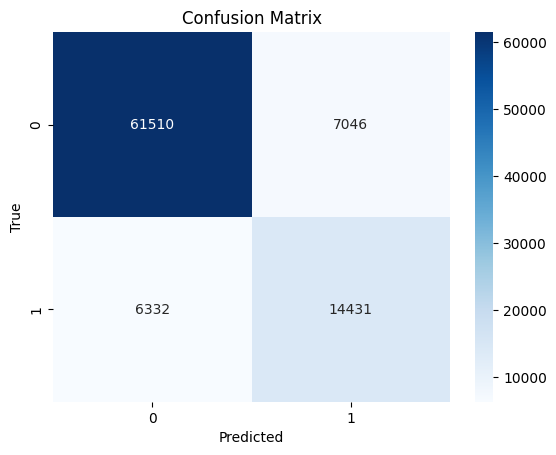

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     68556
           1       0.67      0.70      0.68     20763

    accuracy                           0.85     89319
   macro avg       0.79      0.80      0.79     89319
weighted avg       0.85      0.85      0.85     89319



In [19]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, top_features=top_features, use_smote = True)

# SMOTE ENN

In [20]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE ENN 

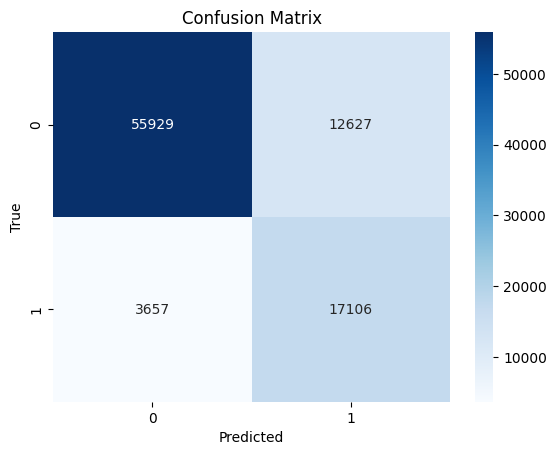

              precision    recall  f1-score   support

           0       0.94      0.82      0.87     68556
           1       0.58      0.82      0.68     20763

    accuracy                           0.82     89319
   macro avg       0.76      0.82      0.78     89319
weighted avg       0.85      0.82      0.83     89319



In [21]:
train_and_evaluate_rf(X_train_scaled, y_smenn, X_test_scaled, y_test)

## Data SMOTE ENN + Tune

[I 2025-05-05 19:43:29,189] A new study created in memory with name: no-name-31286227-0d01-4970-8cb2-3d2d400e6235
[I 2025-05-05 19:44:43,743] Trial 0 finished with value: 0.6843826655764513 and parameters: {'n_estimators': 110, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.55}. Best is trial 0 with value: 0.6843826655764513.
[I 2025-05-05 19:47:25,997] Trial 1 finished with value: 0.667324594071205 and parameters: {'n_estimators': 189, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.45000000000000007}. Best is trial 0 with value: 0.6843826655764513.
[I 2025-05-05 19:51:26,332] Trial 2 finished with value: 0.6841202114831648 and parameters: {'n_estimators': 286, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.6

Best trial:
FrozenTrial(number=5, state=1, values=[0.6912597386010474], datetime_start=datetime.datetime(2025, 5, 5, 19, 57, 45, 702044), datetime_complete=datetime.datetime(2025, 5, 5, 19, 59, 37, 425261), params={'n_estimators': 116, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=5, value=None)
Best hyperparameters:
n_est

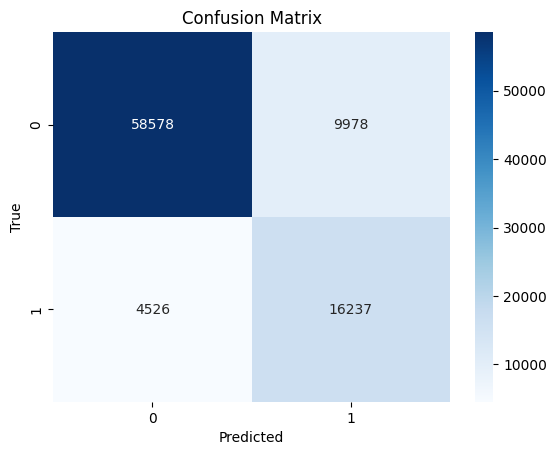

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     68556
           1       0.62      0.78      0.69     20763

    accuracy                           0.84     89319
   macro avg       0.77      0.82      0.79     89319
weighted avg       0.86      0.84      0.84     89319



In [22]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, use_smoteenn = True)

## Data SMOTE ENN + Feature

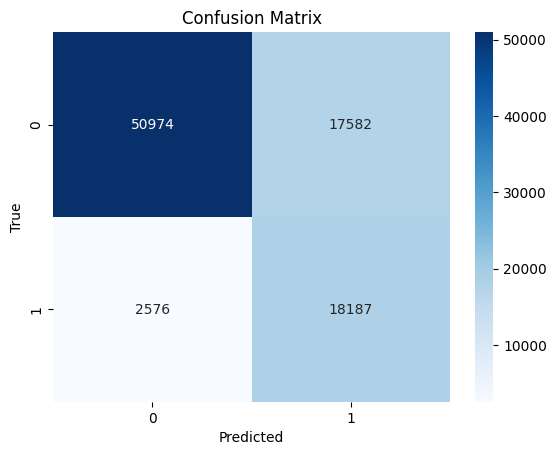

              precision    recall  f1-score   support

           0       0.95      0.74      0.83     68556
           1       0.51      0.88      0.64     20763

    accuracy                           0.77     89319
   macro avg       0.73      0.81      0.74     89319
weighted avg       0.85      0.77      0.79     89319



In [23]:
train_and_evaluate_rf(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE ENN + Feature + Tune

[I 2025-05-05 20:10:27,285] A new study created in memory with name: no-name-69cbefe1-9fa4-4065-bb49-9173f7a6cf84
[I 2025-05-05 20:12:41,440] Trial 0 finished with value: 0.6169266106622548 and parameters: {'n_estimators': 157, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.4}. Best is trial 0 with value: 0.6169266106622548.
[I 2025-05-05 20:15:23,440] Trial 1 finished with value: 0.4898684001902648 and parameters: {'n_estimators': 212, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.9}. Best is trial 0 with value: 0.6169266106622548.
[I 2025-05-05 20:18:06,847] Trial 2 finished with value: 0.6217394111570248 and parameters: {'n_estimators': 249, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.4}. Best is trial

Best trial:
FrozenTrial(number=5, state=1, values=[0.6320331669345968], datetime_start=datetime.datetime(2025, 5, 5, 20, 22, 52, 186544), datetime_complete=datetime.datetime(2025, 5, 5, 20, 25, 22, 550490), params={'n_estimators': 174, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.45000000000000007}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=5, value=None)
Best hyperpa

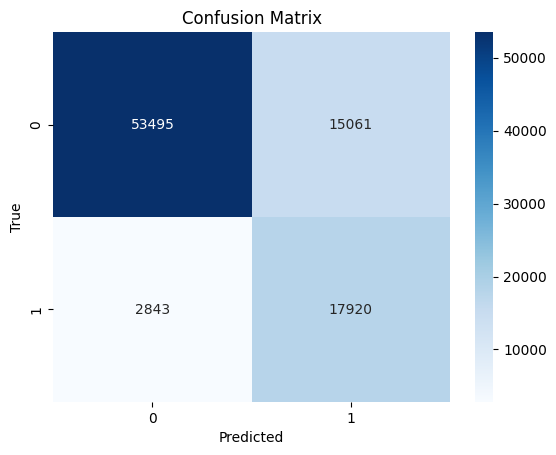

              precision    recall  f1-score   support

           0       0.95      0.78      0.86     68556
           1       0.54      0.86      0.67     20763

    accuracy                           0.80     89319
   macro avg       0.75      0.82      0.76     89319
weighted avg       0.86      0.80      0.81     89319



In [24]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features=top_features,  use_smoteenn = True)